- title: When Regressions Attack
- tags: statistics, week10, bsdetection
- date: 2018-12-3

This lesson is all about what can go wrong in linear regression.  Here's an outline of the ways things can go wrong.

- data isn't linear
    - extreme outliers
- heteroskadiscity
- multicolinnearity
- non-normal residuals
- omitted variable bias
- conditioning on a collider

There's also a problem known as "autocorrelation" which mainly appears in time series data (i.e., when one tries to run a regression on something that changes over time, like stock market prices). Time series analysis is a fairly advanced topic that is beyond the scope of this course, but you should have alarm bells ringing if anyone tries to do ordinary linear regression on data that spans time like that. 

Often, this material is taught in terms of "assumptions of regression."  We say that linear regression assumes certain things about your data/the world that your data represent.  This is kind of indirect language, however. When stats people talk about "assumptions" what they really mean are "things that have to be true or the regression gets the wrong answer."  So we'll just directly talk about the wrong answer and how it can be detected or avoided.

Another way to think about this is as a core part (along with the discussion of p values and power from a couple weeks ago) of your developing a BS detector for statistical claims, offered by scientific studies, expert witnesses, or otherwise.  One way of spewing statistical BS is to report the results of a regression which fails these "assumptions" --- which doesn't actually give you real information.  So in order to keep from being taken in by the BS, you need to know how regressions can go wrong.

We will also cover some of the major diagnostic methods for identifying these problems, however, this will be far from comprehensive. Statsmodels has [a list of the various diagnostics that are built in](https://www.statsmodels.org/dev/diagnostic.html); it's never wrong to google some of those to learn more. 

## Linear Regression: read the first word again.

In a lot of ways, the fundamental technical flaw of bad linear regressions is to use it to attempt to represent nonlinear relationships. Remember that what a linear regression does is draws a line (in two dimensions, a plane, or a *hyperplane* (wooooo) or such in more dimensions) that best allows us to predict the dependent variable from the independent variables.  But what if the relationship isn't linear?  

There's a very famous set of data visualizations, called *Anscombe's quartet*, that illustrates this.  It's so important that they actually built it into seaborn, so we can just directly run an example plot from their own documentation and take a look: 

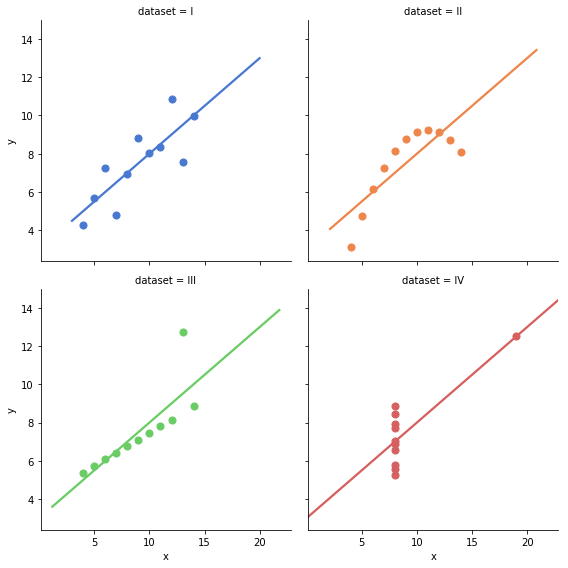

In [1]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm

df = sns.load_dataset("anscombe")

# Show the results of a linear regression within each dataset
sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=df,
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})

Anscombe's quartet is really deep (check out [the wikipedia page](https://en.wikipedia.org/wiki/Anscombe%27s_quartet) for details).  What you're looking at is four distinct datasets that have identical means and variances in both x and y, identical correlation coefficients between x and y, and identical linear regression coefficients with identical r-squareds. (!!!!!)  

We're going to keep coming back to this, but for now I just want you to focus on the top row, and compare the top left with the top right. 

The top left is a great linear regression dataset.  The relationship looks very linear, in the sense that when x increases, y increases, and it looks like by about the same amount, give or take, each time. 

The top right is a terrible linear regression dataset.  You can visibly see that the line that OLS is trying to fit here doesn't even remotely match the shape of the data.  What this means is that you'll get regression coefficients out of this, but they won't mean very much at all, because there isn't actually relationship between x and y about which we can say "when x changes by some amount, y changes by some other amount"; or, at least, if there is such a range it doesn't exist over the entire range of x.  

Sometimes, data transformations can be used to make nonlinear data fit a linear form. The log transformation we looked at a few weeks ago, for example, is pretty good at suppressing some kinds of nonlinearity, though at the cost of making our regression coefficients a bit harder to figure out.  

Here, we might try a polynomial transformation, that is, instead of fitting the regression on x, maybe fit it on x squared, or x cubed.  That can allow the regression line to stop being, well, a line, and turn into a curve, which can more closely fit the data.  Indeed, this will turn out to be a pretty good match for this example.

In [2]:
# first let's carve out all the quartets into separate datasets 
quartet1 = df[df["dataset"] == "I"]
quartet2 = df[df["dataset"] == "II"]
quartet3 = df[df["dataset"] == "III"]
quartet4 = df[df["dataset"] == "IV"]

In [3]:
quartet2

,dataset,x,y
11,II,10.0,9.14
12,II,8.0,8.14
13,II,13.0,8.74
14,II,9.0,8.77
15,II,11.0,9.26
16,II,14.0,8.10
17,II,6.0,6.13
18,II,4.0,3.10
19,II,12.0,9.13
20,II,7.0,7.26


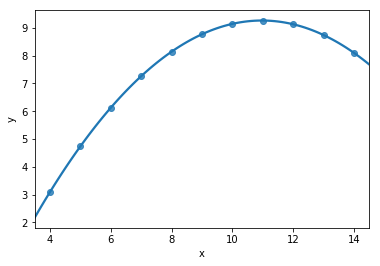

In [4]:
sns.regplot(x="x", y="y", data=quartet2, order=2)

In that code, the `order=2` parameter told seaborn to, behind the scenes, fit a polynomial regression with order 2 (that is, with a squared independent variable---order 3 would be a cubed independent variable) to the data.  So this would more accurately reflect our data, but the price (as with all such transformations) would, yet again, be that the coefficients would be harder to interpret. (When x-squared increases by A, y increases by B... huh?)

There's also another price to using higher-order regressions.  Very high-order polynomials are likely to "overfit."  What's overfitting?  Look at the first dataset in anscombe's quartet again.  What would happen if instead of drawing a straight diagonal line, you drew a line connecting every single point? 


(discussion of overfitting and advantage of parameters in terms of importing assumptions about general form of data rather than just reflecting the data you have, generalization.)

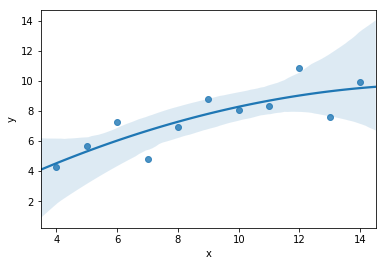

In [5]:
quartet1 = df[df["dataset"] == "I"]
sns.regplot(x="x", y="y", data=quartet1, order=2)

What the high-order polynomials are basically doing here is effectively fitting a line to that runs through more of the points.  But every dataset has error in it, whether it's measurement error or error (variance, really) rooted in the fact that you have a sample.  

By fitting a high degree polynomial, effectively you force the regression to take account of more of the variation between data points.  This is good when that variation is real variation, i.e., reflects the underlying process that generates the data (the thing the scientist is trying to study).  It's bad when the variation is just noise, because noise in your dataset doesn't tell you anything about the real underlying truth in the population.  So it's a bad idea to fit the noise.

What this suggests is that a polynomial regression would be a good idea for #2, because it really looks like there's a kind of polynomial form to the data (a curve).  But it would be a bad idea for #1, because a straight line is probably an adequate model for the data. 



### Extreme Outliers

Go back to Anscombe's quartet at the top of this lesson.  Look at the lower two rows.  Both are examples of how extreme outliers can distort regression results. The problem is that they'll have large squared errors, and so they'll exercise disproportionate influence on the coefficients you ultimately get. 

Outliers are kind of a flavor of nonlinearity, in the sense that often they will be points radically off from a line that does a good job of fitting the other data. But they need not always represent a nonlinearity---there might be an outlier that lies on the same line as the rest of the data, but just has more extreme values on all dimensions.

Outliers are sometimes also called "influential points."

There are a variety of strategies to deal with outliers. Sometimes, there's good theoretical reason to think they're just measurement error and should be removed. (Remember the people in the Shonubi dataset who were supposedly caught carrying 2000 grams of heroin in a single trip?  Uh, no. Someone did a typo that added an extra digit.)  Generally, however, that's a bad idea.  

In this class, we won't address the alternative strategies (techniques like robust regression) used to accommodate outliers. Detecting them is worthwhile though, and sometimes a bit difficult in multivariate context. (In single-variable regression you can just use a scatterplot.)  Statsmodels provides an [influence plot](https://www.statsmodels.org/dev/generated/statsmodels.graphics.regressionplots.influence_plot.html) which can be used to try to pick out individual points. 

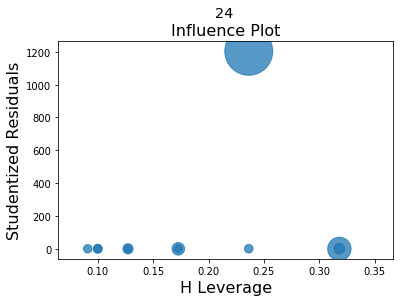

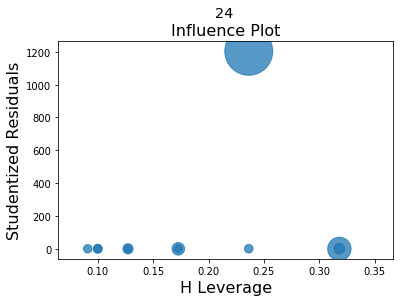

In [11]:
from statsmodels.graphics.regressionplots import influence_plot
results = sm.ols(formula='y ~ x', data=quartet3).fit()

influence_plot(results)

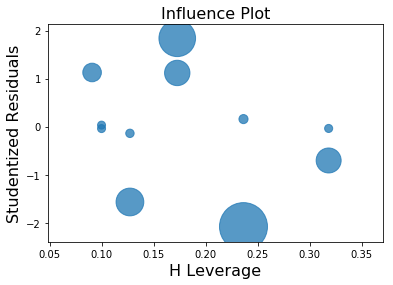

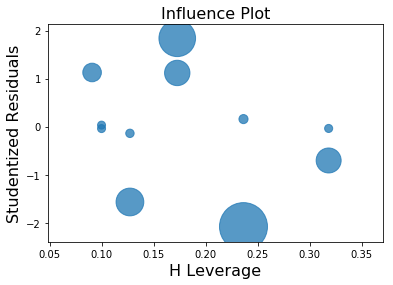

In [13]:
results_better = sm.ols(formula='y ~ x', data=quartet1).fit()

influence_plot(results_better)

## Heteroskedasticity: Scary Word, Simple Idea

One problem that can come from nonlinear relationships in your daya (and other causes) is known as heteroskedasticity.  The basic idea here is different residuals along different parts of the range of the data. 

There's a classic way to see this, which comes from a scatterplot of the residuals vs fitted values.  You'll often see a kind of fan shape in these plots, where as fitted values grow (or shrink) the residuals increase.

Here's an example.  We'll pull down my book dataset again just for an easy dataset with more variables in it.

In [6]:
rol = pd.read_csv("http://rulelaw.net/downloads/rol-scores.csv")
rol.columns = [x.lower().strip() for x in rol.columns]
rol.head()

,state,pop. in millions for 2012,rolscore,elec_pros,pol_plur,free_expr,assoc_org,per_auto,2012gdp,hprop,hfisc,hbiz,hlab,htra,hinv
0,Albania,3.2,42.60,8,10,13,8,9,1.264810e+10,30,92.6,81.0,49.0,79.8,65
1,Argentina,41.1,51.94,11,15,14,11,13,4.755020e+11,15,64.3,60.1,47.4,67.6,40
2,Australia,22.7,73.28,12,15,16,12,15,1.532410e+12,90,66.4,95.5,83.5,86.2,80
3,Austria,8.4,73.15,12,15,16,12,15,3.947080e+11,90,51.1,73.6,80.4,86.8,85
4,Bangladesh,154.7,31.57,9,11,9,8,9,1.163550e+11,20,72.7,68.0,51.9,54.0,55


Annoyingly, there isn't a library method to do a fitted vs residual plot, but we can do it ourselves very easily.

In [7]:
def res_vs_fitted(x, y, data):
    formula = '{} ~ {}'.format(y, x)
    res = sm.ols(formula=formula, data=data).fit()
    return plt.scatter(res.fittedvalues, res.resid)

Ok, let's start by looking at a plot that lacks heteroskedasticity.

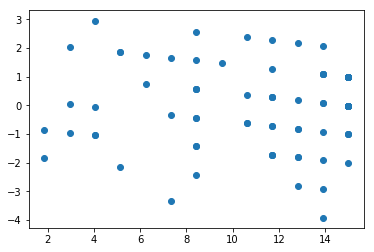

In [8]:
res_vs_fitted(x="elec_pros", y="pol_plur", data=rol)

Note how there's no definiable pattern in the plot of residuals on fits.  That's what you want.  It's a cloud.  An amorphous, lovely, cloud. 

But now, let's screw up the data.  we'll define a function that makes things noisier as the value increases. 

In [9]:
from copy import deepcopy
def make_heteroskedasticity(x, y, data):
    # just making sure I don't accidentally manipulate the underlying data, which 
    # is always a danger with pandas, and too lazy to figure out how to ensure that  
    # inside the dataframe.
    breakx = deepcopy(list(data[x]))
    breaky = deepcopy(list(data[y]))
    stdy = np.std(breaky)
    tw5 = np.percentile(breakx, 25)
    median = np.percentile(breakx, 50)
    sv5 = np.percentile(breakx, 75)
    # now we're going to add more noise to y values corresponding to higher x values.
    for idx, item in enumerate(breakx):
        if (item > tw5) and (item < median):
            breaky[idx] += np.random.normal(loc=0.0, scale=stdy)
        elif (item > median) and (item < sv5):
            breaky[idx] += np.random.normal(loc=0.0, scale=2 * stdy)
        elif item > sv5:
            breaky[idx] += np.random.normal(loc=0.0, scale=3 * stdy)
    return np.array(breaky)

rol['broken_pol_plur'] = make_heteroskedasticity("elec_pros", "pol_plur", rol)
rol[["broken_pol_plur", "pol_plur", "elec_pros"]].head()

,broken_pol_plur,pol_plur,elec_pros
0,9.734471,10,8
1,20.414584,15,11
2,15.000000,15,12
3,15.000000,15,12
4,11.730254,11,9


That should be nice and messed up.  Let's see! 

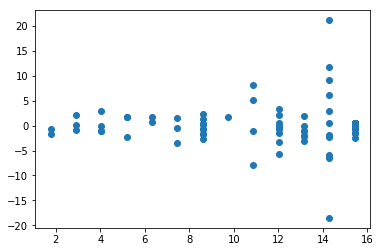

In [10]:
res_vs_fitted(x="elec_pros", y="broken_pol_plur", data=rol)

Ok, so this was a contrived example, but it works: look how the residuals get more dispersed as we get to higher fitted values.  That's the classic fan shape, and it reveals bad heteroskedasticity.  (As well it ought to, since I imposed it on the data by force.) 

The consequence of heteroskedasticity is that our p values will be too low---essentially, OLS will be underestimating the amount of variance in the data, and thus concluding that coefficients are more signifiant than they really are.  Practically speaking, what that means is that finding heteroskedasticity is a great way to bust up a supposed significant result.

Incidentally, a residual vs fitted plot is also a great way to detect nonlinear relationships. For example!  

In [14]:
rol["gdppc"] = rol["2012gdp"] / rol["pop. in millions for 2012"]

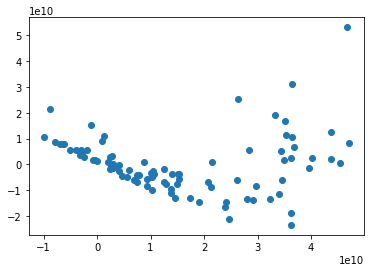

In [15]:
res_vs_fitted(x="rolscore", y="gdppc", data=rol)

Let's look at some of the summary data that statsmodels gives us now.

In [16]:
basic_regression = sm.ols(formula="rolscore ~ elec_pros + per_auto + hprop", data=rol).fit()

In [17]:
basic_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               rolscore   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     223.6
Date:                Thu, 28 Mar 2019   Prob (F-statistic):           9.06e-41
Time:                        18:27:31   Log-Likelihood:                -281.32
No. Observations:                  91   AIC:                             570.6
Df Residuals:                      87   BIC:                             580.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.6512      2.050      5.685      0.000       7.577      15.725
elec_pros     -0.5598      0.265     -2.114      0.037      -1.086      -0.033
per_auto       2.9828      0.415      7.189      0.000       2.158       3.808
hprop          0.2797      0.040      7.000      0.000       0.200       0.359
==============================================================================
Omnibus:                        0.185   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.912   Jarque-Bera (JB):                0.372
Skew:                          -0.001   Prob(JB):                        0.830
Kurtosis:                       2.687   Cond. No.                         201.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""